# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import ipywidgets
import time
import copy

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import  OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor




In [2]:
warnings.filterwarnings('ignore')

In [3]:
try:
    cars = pd.read_csv('/datasets/autos.csv')
except:
    cars  = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
print(cars.duplicated().sum())
cars = cars.drop_duplicates().reset_index(drop=True)
print(cars.duplicated().sum())

4
0


прочитали датасет удалили дубликаты 

In [5]:
display(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

None

In [6]:
cars.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


сразу удалим данные которые не повлияют на цену автомобилья

In [7]:


cars = cars.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')


In [8]:
cars.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


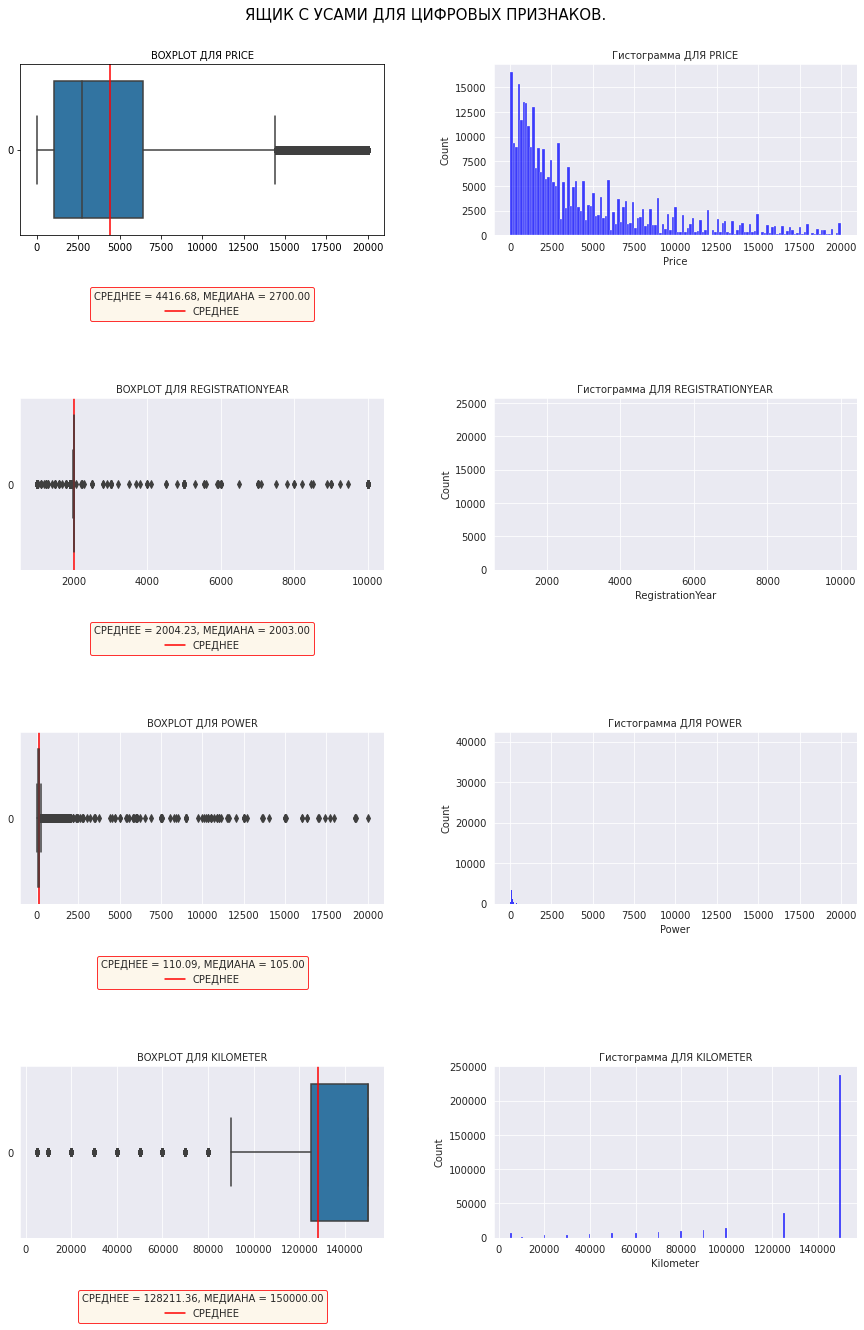

In [9]:
#cars['Model'].unique()
position = 0
num_region = None
plt.figure(figsize=[15, 20])
plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.95)
plt.suptitle('ЯЩИК С УСАМИ ДЛЯ ЦИФРОВЫХ ПРИЗНАКОВ.', fontsize=15)

number = len(cars.loc[:, cars.dtypes == np.int64].dtypes.index)
columns_witn_int = cars.loc[:, cars.dtypes == np.int64].dtypes.index
for column_name in columns_witn_int:
    position += 1
    plt.subplot(number, 2, position)
    plt.title(f'BOXPLOT ДЛЯ {column_name.upper()}', fontsize=10)
    sns.set_style('darkgrid')
    sns.boxplot(data=cars[column_name], orient='h')
    plt.axvline(np.mean(cars[column_name]), 
               color='r', 
               linestyle='-',
               label='СРЕДНЕЕ')
    plt.legend(title=f'СРЕДНЕЕ = {np.mean(cars[column_name]):.2f}, МЕДИАНА = {np.median(cars[column_name]):.2f}', 
               loc='center', 
               edgecolor = 'r',
               facecolor = 'oldlace',
               bbox_to_anchor=(0.5, -0.40))
    position += 1
    plt.subplot(number, 2, position)
    sns.set_style('darkgrid')
    plt.title(f'Гистограмма ДЛЯ {column_name.upper()}', fontsize=10)
    sns.histplot(data=cars[column_name], color='b', kde=False)
plt.show();

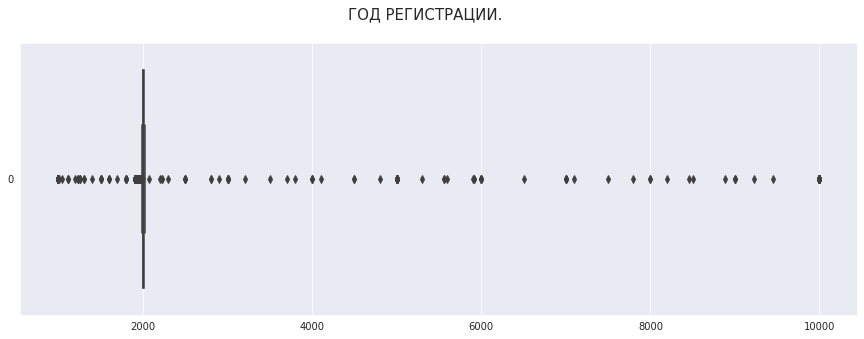

In [10]:
plt.figure(figsize=[15, 5])
plt.suptitle('ГОД РЕГИСТРАЦИИ.', fontsize=15)
sns.set_style('darkgrid')
sns.boxplot(data=cars['RegistrationYear'], orient='h');

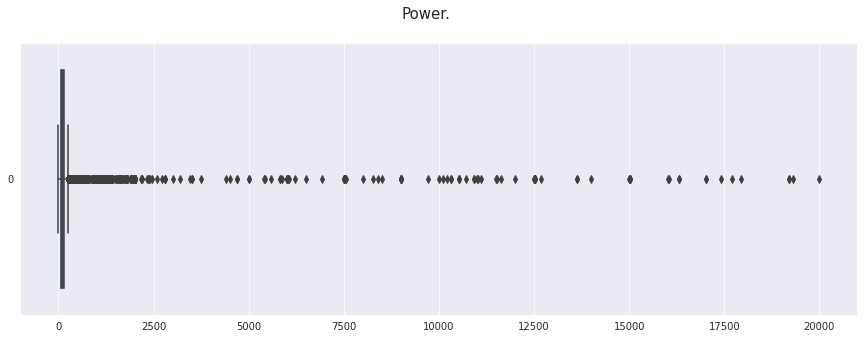

In [11]:
plt.figure(figsize=[15, 5])
plt.suptitle('Power.', fontsize=15)
sns.set_style('darkgrid')
sns.boxplot(data=cars['Power'], orient='h');

In [12]:
cars['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [13]:
cars[cars['Price'] ==0]#многовато

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354201,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


меняем по медиане модели

In [14]:
price=cars.groupby("Model")["Price"].median()
for i in range(len(cars)):
    if cars["Price"][i] ==0:
        try:
            cars["Price"][i]=price[cars["Model"][i]]
        except:
            pass


In [15]:
cars[cars['Price'] ==0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
478,0,NaN,2000,manual,0,NaN,150000,NaN,audi,yes
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
524,0,NaN,2005,manual,136,NaN,100000,NaN,toyota,NaN
563,0,sedan,1998,auto,230,NaN,150000,petrol,saab,NaN
...,...,...,...,...,...,...,...,...,...,...
353175,0,small,1993,manual,45,NaN,150000,petrol,peugeot,yes
353383,0,NaN,2007,manual,0,NaN,50000,petrol,bmw,no
353632,0,NaN,1995,manual,204,NaN,150000,petrol,opel,NaN
353739,0,wagon,2005,manual,163,NaN,150000,gasoline,volkswagen,NaN


меняем по медиане модели

In [16]:

power=cars.groupby("Model")["Power"].median()
for i in range(len(cars)):
    if cars["Power"][i] ==0:
        try:
            cars["Power"][i]=power[cars["Model"][i]]
        except:
            pass

In [17]:
cars[cars['Power'] ==0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
160,500,small,1999,manual,0,NaN,150000,petrol,renault,no
260,450,NaN,2016,manual,0,NaN,150000,petrol,mitsubishi,no
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
308,1600,wagon,1999,manual,0,NaN,150000,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...
354076,4300,small,2008,auto,0,NaN,150000,NaN,honda,NaN
354079,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354158,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN
354334,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN


In [18]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [19]:

cars["Repaired"]=cars["Repaired"].fillna("no")#без ремонта
cars["Repaired"].unique()

array(['no', 'yes'], dtype=object)

меняем пропуски что на unknown

In [20]:

cars["VehicleType"]=cars["VehicleType"].fillna("unknown")
cars['VehicleType'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [21]:

cars["FuelType"]=cars["FuelType"].fillna("unknown")
cars['FuelType'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:

cars["Gearbox"]=cars["Gearbox"].fillna("unknown")
cars['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [23]:
#cars=cars[cars['RegistrationYear'] <= 2023]
cars = (cars[(cars['RegistrationYear'] >= 1985) & (cars['RegistrationYear'] <= 2016)])

удалим пропуски поскольку их мало и модель уже не определить

In [24]:
cars = cars[cars['Model'].isna()!=True]

In [25]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317929 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             317929 non-null  int64 
 1   VehicleType       317929 non-null  object
 2   RegistrationYear  317929 non-null  int64 
 3   Gearbox           317929 non-null  object
 4   Power             317929 non-null  int64 
 5   Model             317929 non-null  object
 6   Kilometer         317929 non-null  int64 
 7   FuelType          317929 non-null  object
 8   Brand             317929 non-null  object
 9   Repaired          317929 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.7+ MB


столбцы категориальных данных

In [26]:
cats = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'RegistrationYear', 'Repaired']

поменяем тип данных на category

In [27]:
for i in cars[cats]:
    cars[i]=cars[i].astype('category')


In [28]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317929 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             317929 non-null  int64   
 1   VehicleType       317929 non-null  category
 2   RegistrationYear  317929 non-null  category
 3   Gearbox           317929 non-null  category
 4   Power             317929 non-null  int64   
 5   Model             317929 non-null  category
 6   Kilometer         317929 non-null  int64   
 7   FuelType          317929 non-null  category
 8   Brand             317929 non-null  category
 9   Repaired          317929 non-null  category
dtypes: category(7), int64(3)
memory usage: 12.1 MB


In [29]:
cars.shape

(317929, 10)

#  Вывод

## Обучение моделей

делим датасет

In [30]:

features = cars.drop(['Price'], axis = 1)  
target = cars['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)
features_train.shape[0], features_valid.shape[0], target_train.shape[0], target_valid.shape[0],features_test.shape[0],target_test.shape[0]

(190757, 63586, 190757, 63586, 63586, 63586)

для замера времени 

In [31]:
def best(model, features_train, target_train, features_valid, target_valid):
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(features_valid)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(target_valid, predict)**0.5

обшие параметры

In [32]:
cv =KFold(random_state=12345, n_splits=5,shuffle=True)

In [33]:
param = {
    'n_estimators': [1,10],
    'max_depth': [6,10],
    'learning_rate':[1]
   
}

# CatBoostRegressor

In [34]:
model_cat = CatBoostRegressor(#iterations=100, 
                          #depth=10, 
                          #learning_rate=1, 
                          loss_function='RMSE',
                          cat_features =cats
                          
                        )

In [35]:
grid_cat = GridSearchCV(model_cat,
                        param,
                        cv=cv,
                        
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [36]:
%%time
grid_cat.fit(features_train, target_train);

0:	learn: 2574.9735790	total: 124ms	remaining: 0us
0:	learn: 2568.5531699	total: 63.2ms	remaining: 0us
0:	learn: 2542.9261184	total: 63.4ms	remaining: 0us
0:	learn: 2578.8299774	total: 62.6ms	remaining: 0us
0:	learn: 2543.7088566	total: 70.4ms	remaining: 0us
0:	learn: 2574.9735790	total: 62.8ms	remaining: 565ms
1:	learn: 2249.7275381	total: 127ms	remaining: 508ms
2:	learn: 2141.9898297	total: 178ms	remaining: 414ms
3:	learn: 2067.3915474	total: 225ms	remaining: 337ms
4:	learn: 2017.1833786	total: 278ms	remaining: 278ms
5:	learn: 1983.9480532	total: 330ms	remaining: 220ms
6:	learn: 1934.7710077	total: 380ms	remaining: 163ms
7:	learn: 1897.9656410	total: 430ms	remaining: 108ms
8:	learn: 1882.1858407	total: 479ms	remaining: 53.2ms
9:	learn: 1866.2852526	total: 531ms	remaining: 0us
0:	learn: 2568.5531699	total: 65.4ms	remaining: 588ms
1:	learn: 2295.5489715	total: 134ms	remaining: 538ms
2:	learn: 2159.3917363	total: 184ms	remaining: 430ms
3:	learn: 2079.7675446	total: 241ms	remaining: 362m

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc280544dc0>,
             param_grid={'learning_rate': [1], 'max_depth': [6, 10],
                         'n_estimators': [1, 10]},
             scoring='neg_mean_squared_error', verbose=False)

In [37]:
grid_cat.best_params_

{'learning_rate': 1, 'max_depth': 10, 'n_estimators': 10}

In [38]:
grid_cat.best_score_
np.sqrt(-1 *grid_cat.best_score_)

1756.005909220501

In [39]:
model_cat = CatBoostRegressor(iterations=10, 
                          depth=10, 
                          learning_rate=1, 
                          loss_function='RMSE',
                          cat_features =cats
                          
                        )

# LGBMRegressor

In [40]:

X, y =features_train,target_train
model_LGBM = LGBMRegressor(#max_depth=10,                        
                        #num_iterations=100,
                        #learning_rate =1,
                        categorical_feature=cats,
                        metric="rmse",
                                                                     
                       )




In [41]:
grid_LGBM = GridSearchCV(model_LGBM,
                        param,
                        cv=cv,                        
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [42]:
%%time
grid_LGBM.fit(X, y);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 14 s, sys: 44.4 ms, total: 14.1 s
Wall time: 14.1 s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(categorical_feature=['VehicleType',
                                                          'Gearbox', 'Model',
                                                          'FuelType', 'Brand',
                                                          'RegistrationYear',
                                                          'Repaired'],
                                     metric='rmse'),
             param_grid={'learning_rate': [1], 'max_depth': [6, 10],
                         'n_estimators': [1, 10]},
             scoring='neg_mean_squared_error', verbose=True)

In [43]:
grid_LGBM.best_params_

{'learning_rate': 1, 'max_depth': 10, 'n_estimators': 10}

In [44]:
np.sqrt(-1 *grid_LGBM.best_score_)

1795.7343978308973

In [45]:
model_LGBM = LGBMRegressor(max_depth=10,                        
                        num_iterations=10,
                        learning_rate =1,
                        categorical_feature=cats,
                        metric="rmse",
                                                                     
                       )




# OHE

In [46]:
oh=cars.copy()
for i in oh[cats]:
    oh[i]=oh[i].astype('object')
    
###############################################################
# data_ohe = pd.get_dummies(oh,columns=cats,drop_first=True)
# t2 = data_ohe['Price']
# f2 = data_ohe.drop('Price', axis=1)
# f2_train, f2_valid, t2_train, t2_valid = train_test_split(f2, t2, test_size=0.4, random_state=12345)
# f2_test, f2_valid, t2_test, t2_valid = train_test_split(f2_valid, t2_valid, test_size=0.5, random_state=12345)


# scaler = StandardScaler()
# scaler.fit(f2_train)
# f2_train = scaler.transform(f2_train)
# f2_valid = scaler.transform(f2_valid)


#################################################################
t2 = oh['Price']
f2 = oh.drop('Price', axis=1)
f2_train, f2_valid, t2_train, t2_valid = train_test_split(f2, t2, test_size=0.4, random_state=12345)
f2_test, f2_valid, t2_test, t2_valid = train_test_split(f2_valid, t2_valid, test_size=0.5, random_state=12345)



en = OneHotEncoder(handle_unknown="ignore")
en.fit(f2_train) 



f2_train = en.transform(f2_train)
f2_valid = en.transform(f2_valid)
f2_test = en.transform(f2_test)


scaler = StandardScaler(with_mean=False)
scaler.fit(f2_train)
f2_train = scaler.transform(f2_train)
f2_valid = scaler.transform(f2_valid)
f2_test = scaler.transform(f2_test)
########################################################


model_ohe = LinearRegression()
f2_train.shape[0]


190757

# LinearRegression

## Анализ моделей

In [47]:
res=[]

res.append(best(model_cat, features_train, target_train, features_valid, target_valid))

0:	learn: 2379.1960777	total: 127ms	remaining: 1.14s
1:	learn: 2062.0276921	total: 246ms	remaining: 985ms
2:	learn: 1940.3766131	total: 357ms	remaining: 834ms
3:	learn: 1890.0103300	total: 462ms	remaining: 693ms
4:	learn: 1844.6780076	total: 558ms	remaining: 558ms
5:	learn: 1791.4700744	total: 658ms	remaining: 439ms
6:	learn: 1757.8409254	total: 761ms	remaining: 326ms
7:	learn: 1733.3709915	total: 860ms	remaining: 215ms
8:	learn: 1707.6235839	total: 955ms	remaining: 106ms
9:	learn: 1687.1663970	total: 1.05s	remaining: 0us


In [48]:
res.append(best(model_LGBM, features_train, target_train, features_valid, target_valid))

In [49]:
res.append(best(model_ohe, f2_train, t2_train, f2_valid, t2_valid))

In [50]:
pd.DataFrame(data=res,
index=['CatBoost','LightGBM','OneHotEncoder' ],
columns=['Время_обучения', 'Время_Предсказания', 'RMSE']).sort_values(ascending=True,by='RMSE')


,Время_обучения,Время_Предсказания,RMSE
CatBoost,1.839719,0.043061,1753.139021
LightGBM,0.918445,0.021594,1803.009592
OneHotEncoder,5.876335,0.002007,1989.709507


In [51]:
predictions_cat = model_cat.predict(features_test)
rmse_cat = mean_squared_error(target_test, predictions_cat) ** 0.5
print( rmse_cat)

1727.7762397328434


# вывод:

по результатам кросс-валидации catboost обучил  лучше и быстрее всех на этих данных.и чем больше итерации и деревя тем больше разница.
хотя параметры были минимальные мы не знаем что будет если оба зарядим по всем параметрам.и один и другой имеют козыри в рукавах и огромный арсенал параметров.
OHE тоже показал не плохие резултаты но опять же крос-валидационные методи не оставят шанса когда даже только итерации  сделаем чуть по больше